In [245]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [260]:
from datasets.carla import *
from models.baseline import *

from tools.utils import *
from tools.loss import *

%matplotlib inline
import matplotlib.pyplot as plt

In [248]:
carla_data = CarlaDataset("../../data/carla/train", False)        
model = Baseline([7], backbone="lss")

Loaded pretrained weights for efficientnet-b0


In [249]:
images, intrinsics, extrinsics, labels = carla_data[0]
images = images[None].to(7)
intrinsics = intrinsics[None].to(7)
extrinsics = extrinsics[None].to(7)
labels = labels[None].to(7)

In [250]:
logits = model(images, intrinsics, extrinsics)
preds = model.activate(logits)
torch.tensor([3., 1., 3., 1.]).to(7)

tensor([3., 1., 3., 1.], device='cuda:7')

In [317]:
focal_loss(logits, labels, n=2, weights=torch.tensor([3., 3., 3., 3.]).to(7)).mean()

tensor(4.2013, device='cuda:7', grad_fn=<MeanBackward0>)


tensor(2.4231, device='cuda:7', grad_fn=<MeanBackward0>)

In [339]:
softmax_focal_loss_with_logits(logits, labels.argmax(dim=1), weights=torch.tensor([3., 3., 3., 3.]).to(7))

tensor(4.2013, device='cuda:7', grad_fn=<MeanBackward0>)


tensor(2.4231, device='cuda:7', grad_fn=<MeanBackward0>)

In [288]:
ce_loss(logits, labels, weights=torch.tensor([3., 3., 3., 3.]).to(7)).mean()

tensor(4.2013, device='cuda:7', dtype=torch.float64, grad_fn=<MeanBackward0>)

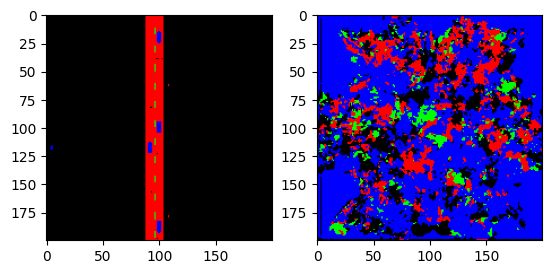

In [253]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(map_rgb(labels[0]) / 255)
axs[1].imshow(map_rgb(preds[0]) / 255)

In [302]:
ce = ce_loss(logits, labels)
probs = logits.softmax(dim=1)
ce

tensor([[[1.0302, 1.1815, 1.2302,  ..., 1.2555, 1.2876, 1.4023],
         [1.1531, 1.2292, 1.2556,  ..., 1.3404, 1.3701, 1.4250],
         [1.2018, 1.1765, 1.1968,  ..., 1.3497, 1.3435, 1.2812],
         ...,
         [1.0676, 1.2021, 1.2632,  ..., 1.3379, 1.4077, 1.2815],
         [1.0722, 1.1759, 1.2307,  ..., 1.2534, 1.2698, 1.2065],
         [1.0577, 1.0218, 1.0195,  ..., 1.0746, 1.0584, 1.0829]]],
       device='cuda:7', dtype=torch.float64, grad_fn=<NegBackward0>)

In [363]:
F.nll_loss(torch.log_softmax(logits, dim=1), labels.argmax(dim=1), weight=torch.tensor([4., 4., 4., 4.]).to(7), reduction='none').mean()

tensor(5.6018, device='cuda:7', grad_fn=<MeanBackward0>)

In [365]:
F.nll_loss(torch.log_softmax(logits, dim=1), labels.argmax(dim=1), weight=torch.tensor([4., 4., 4., 4.]).to(7), reduction='sum') / (4 * 200*200)

tensor(1.4004, device='cuda:7', grad_fn=<DivBackward0>)

In [362]:
F.nll_loss(torch.log_softmax(logits, dim=1), labels.argmax(dim=1), weight=torch.tensor([4., 4., 4., 4.]).to(7), reduction='mean')

tensor(1.4004, device='cuda:7', grad_fn=<NllLoss2DBackward0>)

tensor(10195.6318, device='cuda:7', grad_fn=<SumBackward0>)


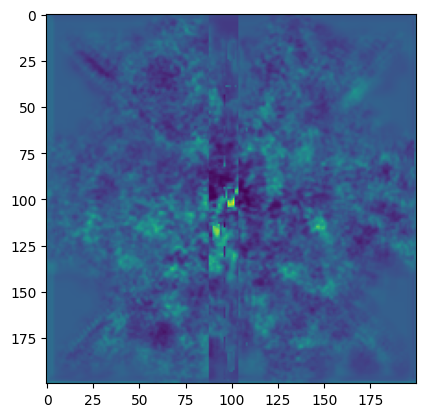

In [309]:
pt = probs.gather(1, labels.argmax(dim=1)[None])
print(pt.sum())
plt.imshow(pt.detach().cpu()[0,0])

In [338]:
def softmax_focal_loss_with_logits(
    output: torch.Tensor,
    target: torch.Tensor,
    gamma: float = 2.0,
    reduction: str = "mean",
    normalized: bool = False,
    reduced_threshold: Optional[float] = None,
    eps: float = 1e-6,
    ignore_index: int = -100,
    weights=None
) -> torch.Tensor:
    """
    Softmax version of focal loss between target and output logits.
    See :class:`~pytorch_toolbelt.losses.FocalLoss` for details.

    Args:
        output: Tensor of shape [B, C, *] (Similar to nn.CrossEntropyLoss)
        target: Tensor of shape [B, *] (Similar to nn.CrossEntropyLoss)
        gamma: Focal loss power factor
        reduction (string, optional): Specifies the reduction to apply to the output:
            'none' | 'mean' | 'sum' | 'batchwise_mean'. 'none': no reduction will be applied,
            'mean': the sum of the output will be divided by the number of
            elements in the output, 'sum': the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`.
            'batchwise_mean' computes mean loss per sample in batch. Default: 'mean'
        normalized (bool): Compute normalized focal loss (https://arxiv.org/pdf/1909.07829.pdf).
        reduced_threshold (float, optional): Compute reduced focal loss (https://arxiv.org/abs/1903.01347).
    """
    k = torch.ones_like(output)

    k *= weights.view(1, -1, 1, 1)
    # k should be bxcxhxw where everything in the c channel has weight of alpha-c
    k = k.gather(1, target[None]) # correct ones only

    log_softmax = F.log_softmax(output, dim=1)

    loss = F.nll_loss(log_softmax, target, reduction="none", ignore_index=ignore_index, weight=weights)
    print(loss.mean())
    pt = torch.exp(-loss / k)


    # compute the loss
    if reduced_threshold is None:
        focal_term = (1.0 - pt).pow(gamma)
    else:
        focal_term = ((1.0 - pt) / reduced_threshold).pow(gamma)
        focal_term[pt < reduced_threshold] = 1

    loss = focal_term * loss

    if normalized:
        norm_factor = focal_term.sum().clamp_min(eps)
        loss = loss / norm_factor

    if reduction == "mean":
        loss = loss.mean()
    if reduction == "sum":
        loss = loss.sum()
    if reduction == "batchwise_mean":
        loss = loss.sum(0)

    return loss
